<a href="https://colab.research.google.com/github/kitkeat/Effective-Argument-Prediction-NLP/blob/main/2-modelling-evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# # ! pip install accelerate nvidia-ml-py3
! pip install datasets==2.1.0
! pip install transformers==4.18.0
! pip install sentencepiece==0.1.96
! pip install pytorch-lightning==1.6.5
! pip install torchmetrics==0.9.2
! pip install wandb==0.12.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 115 kB 43.5 MB/s 
     |████████████████████████████████| 141 kB 34.3 MB/s 
     |████████████████████████████████| 101 kB 8.9 MB/s 
     |████████████████████████████████| 212 kB 30.8 MB/s 
     |████████████████████████████████| 596 kB 32.2 MB/s 
     |████████████████████████████████| 127 kB 55.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |███████████████████████████

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
# run_type = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
pd.set_option("max_colwidth", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk
import re
import unicodedata


from transformers import AutoTokenizer, DataCollatorWithPadding, AdamW, get_cosine_schedule_with_warmup
from datasets import Dataset, Value, ClassLabel, Features, load_metric
from transformers import TrainingArguments, Trainer

from transformers import AutoModel, AutoModelForSequenceClassification
import math

from transformers import EarlyStoppingCallback
import torch
from torch import nn
from torch.utils.checkpoint import checkpoint # need to call when using gradient_checkpointing
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight

from scipy.special import softmax

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from torchmetrics.functional import accuracy,f1_score
from torch.utils.data import DataLoader
import torch.nn.functional as F

import spacy
from spacy import displacy

import wandb

In [4]:
# # Check f1 score calculation
# logits =  torch.tensor([[ 0.0484,  0.2124,  1.6748],
#         [-1.0684,  0.5767,  1.0479],
#         [ 0.0242,  2.3594, -0.2014],
#         [ 1.2988, -1.6455,  0.5952],
#         [-3.3828,  0.1713,  1.2539],
#         [-1.3945,  1.7637,  0.8101],
#         [ 0.2216,  0.3716,  1.0322],
#         [-0.7559,  2.1699,  2.5234],
#         [-3.0879,  0.6777, -0.9976],
#         [ 1.4883, -1.2881,  0.4221],
#         [ 0.4805,  0.1526, -0.6147],
#         [ 0.7354,  1.1416, -0.3162],
#         [-0.9248,  1.0898,  0.0663],
#         [-1.2725, -0.4832, -2.3008],
#         [ 0.2917,  1.3350,  0.0900],
#         [ 4.8086, -1.4307,  0.8926]])

# logits.shape
# label = torch.tensor([0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0])
# # label.shape
# # logits.argmax(dim=1)
# # f1 = f1_score(logits.softmax(dim=1),label,num_classes=3,multiclass=True,average='weighted')
# # f1 = f1_score(logits,label)
# # f1

In [5]:
# np.unique(label.tolist())

In [6]:
# np.unique(label)

In [7]:
# class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(label.tolist()),y=label.tolist())
# class_weights=torch.tensor(class_weights,dtype=torch.float)
# loss_func = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
# loss = loss_func(logits,label)

In [8]:
# loss

In [9]:
# logits.softmax(dim=1)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
from kaggle_secrets import UserSecretsClient
try:
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("wand_api")
    !wandb login {secret_value}
except:
    print("wandb failed to login...")
    


wandb failed to login...


# Configuration

In [10]:

attributes = ["Adequate" ,"Effective","Ineffective"]


# data_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
# test_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.csv')


deberta_config={'name':'deberta',
                'model_name': '../input/deberta-v3-base/deberta-v3-base',
                'PATH' : '../input/debertav3basefinetuned3172022/deberta_E3Size16Lr3e-05Warm0.01Weight0.01Freeze2Drop0.1Text0.pth',
                'n_labels': 3,
                'batch_size': 16,
                'lr': 3e-5,
                'warmup': 0.01, 
                'weight_decay': 0.01,
                'n_epochs': 4,
                'n_freeze' : 2,#9,
                'p_dropout':0.65,
                'text_method': 2
                }

distilbert_config={'name': 'distilbert',
                'model_name': '../input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad',
                'PATH' : '../input/distilberttuned/distilbert-frozenembedding2transformlayer-5epoch-lr6e5-drop02.pth',
                'n_labels': 3,
                'batch_size': 64,
                'lr': 8e-4,#6e-5,
                'warmup': 0.2, 
                'weight_decay': 0.001,
                'n_epochs': 5,#4,
                'n_freeze' : 3,
                'p_dropout':0.6,#0.2,#0.6,
                'text_method': 1
                }

bertofa_config={'name':'bertofa',
                'model_name': '../input/bertlargeuncasedsparse90unstructuredpruned/bert-large-uncased-sparse-90-unstructured-pruneofa',
                'PATH' : '../input/bert-ofa-pretuned3072022/Bert_OFA_E3Size64Lr0.0001Warm02Weight1e-06Freeze21Drop001_full.pth',
                'n_labels': 3,
                'batch_size': 64,
                'lr': 1e-4,
                'warmup': 0.2, 
                'weight_decay': 1e-6,
                'n_epochs': 3,
                'n_freeze' : 21,
                'p_dropout':0.1,
                'text_method': 2
                }

distilroberta_config={'name':'distilroberta',
                'model_name': '../input/distilrobertabase/distilroberta-base',
                'PATH' : '../input/distilrobertafinetuned3072022/epoch7-step1840.pth',
                'n_labels': 3,
                'batch_size': 128,
                'lr': 6e-5,
                'warmup': 0.2, 
                'weight_decay': 0.001,
                'n_epochs': 10,
                'n_freeze' : 5,
                'p_dropout':0,
                'text_method': 2
                }

seed_everything(91, workers=True)

INFO:pytorch_lightning.utilities.seed:Global seed set to 91


91

# Utility

In [ ]:
def get_essay(essay_id, is_train=True):
    INPUT_DIR = '../input/feedback-prize-effectiveness/'
    parent_path = INPUT_DIR + 'train' if is_train else INPUT_DIR + 'test'
    
    try:
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()
    except:
        parent_path = INPUT_DIR + 'train'
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()        
    return essay_text

def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters


# from text_unidecode import unidecode
# from typing import Dict, List, Tuple
# import codecs

# def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
#     return error.object[error.start : error.end].encode("utf-8"), error.end


# def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
#     return error.object[error.start : error.end].decode("cp1252"), error.end

# # Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
# codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
# codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

# def resolve_encodings_and_normalize(text: str) -> str:
#     """Resolve the encoding problems and normalize the abnormal characters."""
#     text = (
#         text.encode("raw_unicode_escape")
#         .decode("utf-8", errors="replace_decoding_with_cp1252")
#         .encode("cp1252", errors="replace_encoding_with_utf8")
#         .decode("utf-8", errors="replace_decoding_with_cp1252")
#     )
#     text = unidecode(text)
#     return text

def normalizecodec(row):
    row = unicodedata.normalize("NFKD", row)
    row = re.sub(r'\n',' ',row)
    return row

# Dataset

---

In [ ]:
class _Dataset(Dataset):
    def __init__(self,data_path,test_path, tokenizer,label_encoder,attributes, max_token_len: int = 512, is_train=True,is_test=False, text_method=0):
        self.data_path = data_path
        self.test_path = test_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.is_train = is_train
        self.is_test = is_test
        self.label_encoder = label_encoder
        self.text_method = text_method
        self._prepare_data()

    def _prepare_data(self):



        SEP = self.tokenizer.sep_token # different model uses different to text as seperator (e.g. [SEP], </s>)
        if self.is_test:
#             df = pd.read_csv(self.test_path)
            df = self.test_path
            try:
                df['essay_text']  = df['essay_id'].apply(lambda x: get_essay(x, is_train=False))
            except:
                print("Fail to get essay")
            df['discourse_text'] = df['discourse_text'].apply(normalizecodec)
            df['discourse_text'] = df['discourse_text'].replace(r'\n',' ', regex=True)
            
            try:
                if self.text_method == 0:
                    df['text'] = df['discourse_text']
                elif self.text_method == 1:
                    df['text'] = df['discourse_type'] + SEP + df['discourse_text']
                elif self.text_method == 2:
                    df['text'] = df['discourse_type'] + ' ' + df['discourse_text'] + SEP + df['essay_text'] # BERT was trained on 2 sentences
            except:
                df['text'] = df['discourse_text']
                
            try:
                # Validation use
                df = df.loc[:,['text','labels']]
            except:
                # Test use
                df = df.loc[:,['text']]

        else:
#             df = pd.read_csv(self.data_path)
            df = self.data_path
            df = df.sample(5000)
            try:
                df['essay_text']  = df['essay_id'].apply(lambda x: get_essay(x, is_train=True))
            except:
                print('Fail to get essay')
                
            y = df['discourse_effectiveness']

            train_df, val_df = train_test_split(df, test_size=0.2,stratify=y,random_state=91)

            if self.is_train:
                df = train_df.copy()
            else:
                df = val_df.copy()

            df['discourse_text'] = df['discourse_text'].apply(normalizecodec)
            df['discourse_text'] = df['discourse_text'].replace(r'\n',' ', regex=True)
            try:
                if self.text_method == 0:
                    df['text'] = df['discourse_text']
                elif self.text_method == 1:
                    df['text'] = df['discourse_type'] + SEP + df['discourse_text']
                elif self.text_method == 2:
                    df['text'] = df['discourse_type'] + ' ' + df['discourse_text'] + SEP + df['essay_text'] # BERT was trained on 2 sentences
            except:
                df['text'] = df['discourse_text']
                
            df = df.rename(columns={'discourse_effectiveness':'labels'})
            df = df.loc[:,['text','labels']]
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        item = self.df.iloc[index]
        text = str(item.text)
        tokens = self.tokenizer.encode_plus(text,
                                  add_special_tokens= True,
                                  return_tensors='pt',
                                  truncation=True,
#                                   padding='max_length',
                                  max_length=self.max_token_len,
                                  return_attention_mask = True)
        if self.is_test:
            return {'input_ids':tokens.input_ids.flatten(),'attention_mask': tokens.attention_mask.flatten()}
        else:
            # # Convert strings to numerics, follow alphabetical order
            attributes = item['labels'].split()
            self.label_encoder.fit(self.attributes)
            attributes = self.label_encoder.transform(attributes)
            attributes = torch.as_tensor(attributes)
            #         attributes = torch.FloatTensor(item[self.attributes])
        return {'input_ids':tokens.input_ids.flatten(),'attention_mask': tokens.attention_mask.flatten(), 'labels':attributes}


# Collate (Dynamic Padding)

In [ ]:
class Collate:
    def __init__(self, tokenizer, isTrain=True):
        self.tokenizer = tokenizer
        self.isTrain = isTrain
        # self.args = args

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        if self.isTrain:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s.tolist() + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s.tolist() + (batch_max - len(s)) * [0] for s in output["attention_mask"]]

#             output["input_ids"] = [torch.cat(s, torch.FloatTensor((batch_max - len(s)) * [0]), 0) for s in output["input_ids"]]
#             output["attention_mask"] = [torch.cat(s, torch.FloatTensor((batch_max - len(s)) * [0]), 0) for s in output["attention_mask"]]
        else:
            output["input_ids"] = [torch.FloatTensor((batch_max - len(s)) * [self.tokenizer.pad_token_id].tolist()) + s.tolist() for s in output["input_ids"]]
            output["attention_mask"] = [torch.FloatTensor((batch_max - len(s)) * [0]) + s.tolist() for s in output["attention_mask"]]
            
        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        if self.isTrain:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)
        return output



# Data Module

---

In [ ]:
class _Data_Module(pl.LightningDataModule):

    def __init__(self, data_path, test_path,attributes,label_encoder,tokenizer, model_name, batch_size: int = 8, max_token_length: int = 512,text_method=0 ):
        super().__init__()
        self.data_path = data_path
        self.test_path = test_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = tokenizer #AutoTokenizer.from_pretrained(model_name)
        self.label_encoder = label_encoder
        self.text_method = text_method

    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder,  attributes=self.attributes, is_train=True, tokenizer=self.tokenizer,text_method=self.text_method)
            self.val_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder, attributes=self.attributes, is_train=False,  tokenizer=self.tokenizer,text_method=self.text_method)
        if stage == 'predict':
            self.test_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder, attributes=self.attributes, is_train=False,is_test=True, tokenizer=self.tokenizer,text_method=self.text_method)


    def train_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=True)

        return DataLoader(self.train_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=True,
                          collate_fn = collate_fn)

    def val_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=True)

        return DataLoader(self.val_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=False,
                          collate_fn = collate_fn)

    def predict_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=False)

        return DataLoader(self.test_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=False,
                          collate_fn = collate_fn)


# Classifier

---

## BertOFA Classifier

In [ ]:
class BertOFA_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = False)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
#         pooled_output = torch.mean(outputs.last_hidden_state, 1) 
#         pooled_output = self.dropout(pooled_output)
#         pooled_output = self.dropout(outputs[1])
        pooled_output = self.hidden(outputs[1])
        pooled_output = F.relu(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

## DistilBert classifier

In [ ]:
class DistilBert_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).transformer.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
#         self.hidden2 = torch.nn.Linear(self.pretrained_model.config.hidden_size,100)

#         self.batchnorm = nn.BatchNorm1d(self.pretrained_model.config.hidden_size)
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1) 
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
#         pooled_output = self.batchnorm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
            
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
#     def training_step(self, batch, batch_index):
#         logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
# #         print(f"batch[labels] = {batch['labels']}")
# #         print(f"{type(batch['labels'])}")
#         class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(batch['labels'].tolist()),y=batch['labels'].tolist())
#         class_weights=torch.tensor(class_weights,dtype=torch.float)
#         loss_func = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to('cuda:0')
#         loss = loss_func(logits,batch['labels']).to('cuda:0')
        
#         f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
#         f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
#         wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
#         self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
#         return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
#     def validation_step(self, batch, batch_index):
#         logits = self(**batch)
# #         print(f"batch[labels] = {batch['labels']}")
#         class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(batch['labels'].tolist()),y=batch['labels'].tolist())
#         class_weights=torch.tensor(class_weights,dtype=torch.float)
#         loss_func = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to('cuda:0')
#         loss = loss_func(logits,batch['labels']).to('cuda:0')
        
        
#         f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
#         f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
#         wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
#         self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
#         return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}
#     
#     def predict_step(self, batch, batch_index):
#         logits = self(**batch)
#         return logits

    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits
    
    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        print(train_size)
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

## Deberta Classifier

In [ ]:
class DeBerta_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module = data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))

        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        # deBERTa layer
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

        ## instead of only using the first token from the output, we will take the mean of all the tokens in the outputs to learn the representation of the entire sentence
        ## pooled_output is the output before going into the final classifier
        pooled_output = torch.mean(output.last_hidden_state, 1) 
        
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

Information

logit shape =  torch.Size([16, 3])
loss shape =  torch.Size([])
logits =  tensor([[ 0.0484,  0.2124,  1.6748],
        [-1.0684,  0.5767,  1.0479],
        [ 0.0242,  2.3594, -0.2014],
        [ 1.2988, -1.6455,  0.5952],
        [-3.3828,  0.1713,  1.2539],
        [-1.3945,  1.7637,  0.8101],
        [ 0.2216,  0.3716,  1.0322],
        [-0.7559,  2.1699,  2.5234],
        [-3.0879,  0.6777, -0.9976],
        [ 1.4883, -1.2881,  0.4221],
        [ 0.4805,  0.1526, -0.6147],
        [ 0.7354,  1.1416, -0.3162],
        [-0.9248,  1.0898,  0.0663],
        [-1.2725, -0.4832, -2.3008],
        [ 0.2917,  1.3350,  0.0900],
        [ 4.8086, -1.4307,  0.8926]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
logits['labels'] = tensor([0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0], device='cuda:0')

# Distil RoBerta Classifer

In [ ]:
class DistilRoBerta_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']]) # 5 layer
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        logits = self.classifier(pooled_output)        
#         pooled_output = self.hidden(pooled_output)
#         pooled_output = F.relu(pooled_output)
#         pooled_output = self.dropout(pooled_output)
        
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
            #wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

# Training

In [ ]:
def train(config,Text_Classifier,project,samplesize, notes,text_method=0):
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    data_module = _Data_Module(data_path,
                                    test_path,
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method=text_method
                                   )
    data_module.setup()
    
    # model
    model = Text_Classifier(config,data_module)

    # trainer and fit
    trainer = pl.Trainer(max_epochs=config['n_epochs'],
                         accelerator='auto',
                         callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience = 3),TQDMProgressBar(refresh_rate=30)],
                         default_root_dir="./checkpoints",
                         precision = 16,
                        ) # automatic mixed precision to reduce memory

    # Create a W&B Run
    run = wandb.init(name = f"E{config['n_epochs']}Size{config['batch_size']}Lr{config['lr']}Warm{config['warmup']}Weight{config['weight_decay']}Freeze{config['n_freeze']}Drop{config['p_dropout']}Text{config['text_method']}" + samplesize,
                     notes = str(config) + notes,
                     project=project)
    trainer.fit(model, data_module)
    
    run.finish()
    
    PATH = f"./{config['name']}_E{config['n_epochs']}Size{config['batch_size']}Lr{config['lr']}Warm{config['warmup']}Weight{config['weight_decay']}Freeze{config['n_freeze']}Drop{config['p_dropout']}Text{config['text_method']}.pth"
    config['PATH'] = PATH
    torch.save(model.state_dict(), PATH)
    
    return model,config


In [ ]:
# bertofa_model,bertofa_config = train(config = bertofa_config,
#                       Text_Classifier = BertOFA_Text_Classifier,
#                       project = 'BertOFA_Text_Classifier',
#                       samplesize = ' full',
#                       notes = 
#                       """
#                         outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask), 
#                         pooled_output = self.hidden(outputs[1]), 
#                         pooled_output = F.relu(pooled_output), 
#                         pooled_output = self.hidden(pooled_output), 
#                         pooled_output = F.relu(pooled_output), 
#                         pooled_output = self.dropout(pooled_output), 
#                         logits = self.classifier(pooled_output)
#                         """)

In [ ]:
# distilroberta_model,distilroberta_config = train(config = distilroberta_config,
#                       Text_Classifier = DistilRoBerta_Text_Classifier,
#                       project = 'DistilRoBerta_Text_Classifier',
#                       samplesize = ' Full',
#                       notes = 
# """
# output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask),
# pooled_output = torch.mean(output.last_hidden_state, 1), 
# logits = self.classifier(pooled_output)  
# """)

In [ ]:
# distilbert_model, distilbert_config  = train(config = distilbert_config,
#                                       Text_Classifier = DistilBert_Text_Classifier,
#                                       project = 'DistilBert_Text_Classifier',
#                                       samplesize = ' 5000 test without weighted loss',
#                                       notes = 
# """
# output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask),
# pooled_output = torch.mean(output.last_hidden_state, 1),
# pooled_output = self.hidden(pooled_output),
# pooled_output = F.relu(pooled_output),
# pooled_output = self.dropout(pooled_output),
# logits = self.classifier(pooled_output)
# """)

In [ ]:
# deberta_model,deberta_config = train(config = deberta_config,
#                       Text_Classifier = DeBerta_Text_Classifier,
#                       project = 'DeBerta_Text_Classifier',
#                       samplesize = ' full',
#                       notes = 
# """
# pooled_output = self.dropout(pooled_output), 
# pooled_output = self.hidden(pooled_output), 
# pooled_output = F.relu(pooled_output), 
# pooled_output = self.dropout(pooled_output), 
# logits = self.classifier(pooled_output)
# """)

# Validation

In [ ]:
def validate(_Text_Classifier,config,data_path,val_path,attributes):    
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    val_data_module = _Data_Module(data_path,
                                    val_path, # using 
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method = config['text_method']
                                   )
    val_data_module.setup()

    # Initialize Model
    model = _Text_Classifier(config,val_data_module)
    model.load_state_dict(torch.load(config['PATH']))

    # Initialize Trainer
    trainer = pl.Trainer(accelerator='auto')

    run = wandb.init(name = f"Validation",notes = str(config),project= 'Validation')
    
    logits = trainer.predict(model, datamodule=val_data_module)

    run.finish()
    
    pred_list = []
    for logit in logits:
        pred_list.append(logit)
    y_pred = torch.cat(pred_list)

    argmax_output = y_pred.argmax(dim=1)
    argmax_output = argmax_output.numpy()
    
    val_df = val_path.copy()
    output_df = pd.concat([val_df.reset_index(drop=True), pd.DataFrame(argmax_output,columns=['pred_discourse_effectiveness'])], axis=1)
    output_df['pred_discourse_effectiveness'] = output_df['pred_discourse_effectiveness'].map({0:'Adequate',1:'Effective',2:'Ineffective'})
    # Plot Confusion Matrix
#     y_true = output_df['discourse_effectiveness'].values
#     y_pred = output_df['pred_discourse_effectiveness'].values
#     ax= plt.subplot()
#     do_conf_matrix(y_true, y_pred, ax=ax)

    return output_df,y_pred

## Retrieve Validation Data set from train test split

In [ ]:
# data_path = '/kaggle/input/feedback-prize-effectiveness/train.csv'
# test_path = '/kaggle/input/feedback-prize-effectiveness/test.csv'
# val_path = './val.csv'
attributes = ["Adequate" ,"Effective","Ineffective"]

# Create validation csv file from traintestsplit
df = data_path.copy()
y = df['discourse_effectiveness']
train_df,val_df = train_test_split(df, test_size=0.2,stratify=y,random_state=91)
# y = val_df['discourse_effectiveness']
# train_df,val_df = train_test_split(val_df, test_size=0.01,stratify=y,random_state=91)
val_path = val_df

In [ ]:
val_df['discourse_effectiveness'].value_counts()

Adequate       4196
Effective      1865
Ineffective    1292
Name: discourse_effectiveness, dtype: int64

## Run Validation

In [ ]:
# val_output_df_distilbert, y_pred_distilbert = validate(DistilBert_Text_Classifier,
#                                                       distilbert_config,
#                                                       data_path,
#                                                       val_path,
#                                                       attributes)

# val_output_df_deberta,y_pred_deberta = validate(DeBerta_Text_Classifier,
#                                                   deberta_config,
#                                                   data_path,
#                                                   val_path,
#                                                   attributes)

# val_output_df_bertofa, y_pred_bertofa = validate(BertOFA_Text_Classifier,
#                                                   bertofa_config,
#                                                   data_path,
#                                                   val_path,
#                                                   attributes)

In [ ]:
## val_output_df_distilroberta, y_pred_distilroberta = validate(DistilRoBerta_Text_Classifier,
##                                                               distilroberta_config,
##                                                               data_path,
##                                                               val_path,
##                                                               attributes)

## Save Validation Results

In [ ]:
# df_distilbert = pd.concat([val_output_df_distilbert.reset_index(drop=True),pd.DataFrame(y_pred_distilbert.tolist(),columns=attributes)],axis=1)
# df_deberta = pd.concat([val_output_df_deberta.reset_index(drop=True),pd.DataFrame(y_pred_deberta.tolist(),columns=attributes)],axis=1)
# df_bertofa = pd.concat([val_output_df_bertofa.reset_index(drop=True),pd.DataFrame(y_pred_bertofa.tolist(),columns=attributes)],axis=1)

# df_distilbert.to_csv('./distilbert_valresult.csv',index=False)
# df_deberta.to_csv('./deberta_valresult.csv',index=False)
# df_bertofa.to_csv('./bertofa_valresult.csv',index=False)


# Explore Validation Results

---

## Read data from Validation

In [ ]:
df_distilbert=pd.read_csv('../input/validation-result/distilbert_valresult.csv')
df_deberta=pd.read_csv('../input/validation-result/deberta_valresult.csv')
df_bertofa=pd.read_csv('../input/validation-result/bertofa_valresult.csv')

ypred_distilbert = torch.from_numpy(df_distilbert.loc[:,['Adequate','Effective','Ineffective']].values)
ypred_deberta = torch.from_numpy(df_deberta.loc[:,['Adequate','Effective','Ineffective']].values)
ypred_bertofa = torch.from_numpy(df_bertofa.loc[:,['Adequate','Effective','Ineffective']].values)


In [ ]:
weight ={
        'deberta':0.10,
        'distilbert':0.50,
        'bertofa':0.40,
#         'distilroberta':0.25
        }



# weight ={
#         'deberta':0.33,
#         'distilbert':0.33,
#         'bertofa':0.33,
# #         'distilroberta':0.25
#         }

## Utility Function for Exploration

In [ ]:
def pred_to_argmax(y_pred,df,model_name):
    argmax_output = y_pred.argmax(dim=1)
    argmax_output = argmax_output.numpy()
    df = pd.concat([df.reset_index(drop=True),pd.DataFrame(argmax_output,columns=[f'pred_effectiveness_{model_name}'])], axis=1)
    df[f'pred_effectiveness_{model_name}'] = df[f'pred_effectiveness_{model_name}'].map({0:'Adequate',1:'Effective',2:'Ineffective'})
    return df

# def plot_confusionmatrix(df,model_name):
#     y_true = output_df['discourse_effectiveness'].values
#     y_pred = output_df[f'pred_discourse_effectiveness_{model_name}'].values
#     ax= plt.subplot()
#     do_conf_matrix(y_true, y_pred, ax=ax)

def do_conf_matrix(y_true, y_pred, ax, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=attributes)
    cm

    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax, cmap='Blues');  
    
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix - {title}'); 

    ax.xaxis.set_ticklabels(attributes)
    ax.yaxis.set_ticklabels(attributes);

    
def calculate_score(y_pred,df):
    cel = nn.CrossEntropyLoss()
    f1 = f1_score(y_pred.argmax(dim=1),torch.tensor(df['discourse_effectiveness_numeric'].values),num_classes=3,average=None)
    f1_weighted = f1_score(y_pred.softmax(dim=1),torch.tensor(df['discourse_effectiveness_numeric'].values),num_classes=3,multiclass=True,average='weighted')
    loss = cel(y_pred,torch.tensor(df['discourse_effectiveness_numeric'].values))
    
    return f1, f1_weighted, loss
    
def validate_result(y_pred_deberta,y_pred_distilbert,y_pred_bertofa,weight,val_path,preds):

#     y_pred_overall = (y_pred_deberta*weight[preds[0]] + y_pred_distilbert*weight[preds[1]] + y_pred_bertofa*weight[preds[2]])/(weight[preds[0]]+weight[preds[1]]+weight[preds[2]])
    
    weight_deberta = torch.tensor([weight['deberta']])
    weight_distilbert = torch.tensor([weight['distilbert']])
    weight_bertofa = torch.tensor([weight['bertofa']])

    weight_deberta=weight_deberta.repeat(ypred_deberta.shape[0],1)
    weight_distilbert=weight_distilbert.repeat(ypred_distilbert.shape[0],1)
    weight_bertofa=weight_bertofa.repeat(ypred_bertofa.shape[0],1)

#     Method 1
#     for idx,ypred in enumerate(ypred_deberta):
#         if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):
#             ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
#             ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
#             weight_deberta[idx]=0.35
#             weight_bertofa[idx]=(1-weight_deberta[idx])*ratio_bertofa
#             weight_distilbert[idx]=(1-weight_deberta[idx])*ratio_distilbert

# Method 3
    for idx,ypred in enumerate(ypred_deberta):
        if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):# & (ypred_distilbert[idx][2]>ypred_distilbert[idx][0]) &(ypred_distilbert[idx][2]>ypred_distilbert[idx][1]):
            ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
            ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
            weight_deberta[idx]=0.6
            weight_bertofa[idx]=0.02
            weight_distilbert[idx]=0.38 

    
    numerator = torch.mul(ypred_deberta,weight_deberta) + torch.mul(ypred_distilbert,weight_bertofa) + torch.mul(ypred_bertofa,weight_distilbert)
    denominator = torch.add(torch.add(weight_deberta,weight_bertofa),weight_distilbert)
    y_pred_overall = torch.div(numerator,denominator)
    
#         # Method 2
#     for idx,ypred in enumerate(y_pred_overall):
#         if ypred[]
#         if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1])& (ypred_distilbert[idx][2]<ypred_distilbert[idx][0])& (ypred_distilbert[idx][2]<ypred_distilbert[idx][1]):
#             ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
#             ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
#             weight_deberta[idx]=0.35
#             weight_bertofa[idx]=(1-weight_deberta[idx])*ratio_bertofa
#             weight_distilbert[idx]=(1-weight_deberta[idx])*ratio_distilbert  
    
    df = val_path.copy()
    df['discourse_effectiveness_numeric'] = df['discourse_effectiveness'].map({'Adequate':0,'Effective':1,'Ineffective':2})
    y_true = df['discourse_effectiveness'].values
    

    
    fig, axs = plt.subplots(2,2,figsize=(20, 10))
    
    df = pred_to_argmax(y_pred_deberta,df,preds[0])    
    df = pred_to_argmax(y_pred_distilbert,df,preds[1])
    df = pred_to_argmax(y_pred_bertofa,df,preds[2])
    df = pred_to_argmax(y_pred_overall,df,preds[3])
    
    print(df.info())
    do_conf_matrix(y_true, df[f'pred_effectiveness_deberta'].values, ax=axs[0,0],title = preds[0])
    do_conf_matrix(y_true, df[f'pred_effectiveness_distilbert'].values, ax=axs[1,0],title = preds[1])
    do_conf_matrix(y_true, df[f'pred_effectiveness_bertofa'].values, ax=axs[0,1],title = preds[2])
    do_conf_matrix(y_true, df[f'pred_effectiveness_OVERALL'].values, ax=axs[1,1],title = preds[3])

    output1 = calculate_score(y_pred_deberta,df)
    output2 = calculate_score(y_pred_distilbert,df)
    output3 = calculate_score(y_pred_bertofa,df)
    output4 = calculate_score(y_pred_overall,df)

    return output1, output2, output3, output4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   discourse_id                     7353 non-null   object
 1   essay_id                         7353 non-null   object
 2   discourse_text                   7353 non-null   object
 3   discourse_type                   7353 non-null   object
 4   discourse_effectiveness          7353 non-null   object
 5   discourse_effectiveness_numeric  7353 non-null   int64 
 6   pred_effectiveness_deberta       7353 non-null   object
 7   pred_effectiveness_distilbert    7353 non-null   object
 8   pred_effectiveness_bertofa       7353 non-null   object
 9   pred_effectiveness_OVERALL       7353 non-null   object
dtypes: int64(1), object(9)
memory usage: 574.6+ KB
None


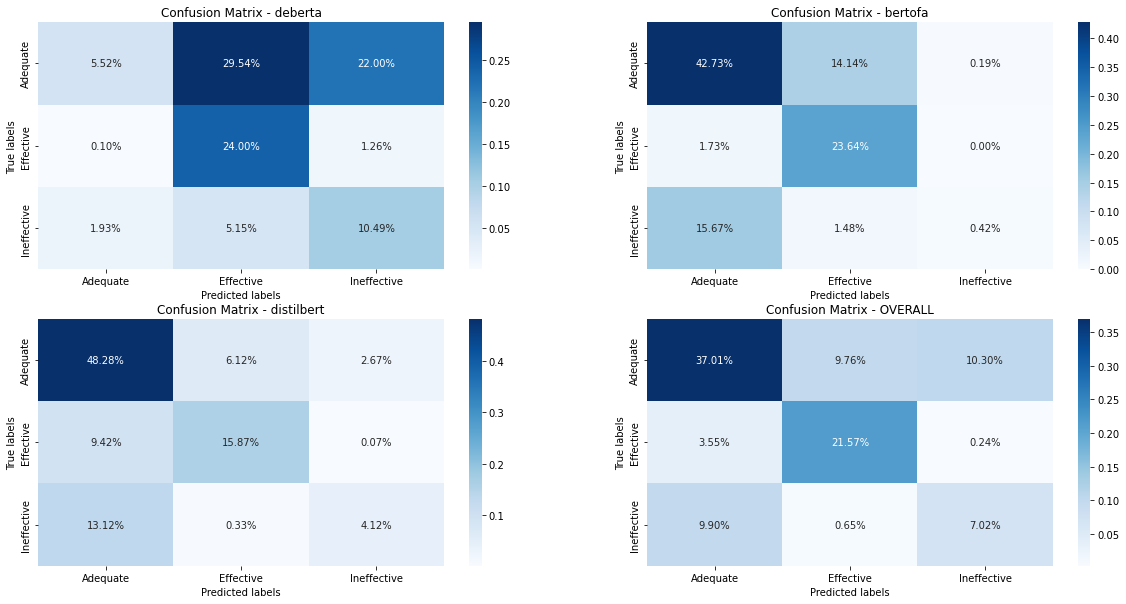

In [ ]:

preds = ['deberta','distilbert','bertofa','OVERALL']

output1, output2, output3, output4 = validate_result(ypred_deberta,ypred_distilbert,ypred_bertofa,weight,val_path, preds)



## Read F1 Score

In [ ]:

f1_score_df = pd.DataFrame({'deberta':output1[0].tolist(),
                         'distilbert':output2[0].tolist(),
                         'bertofa':output3[0].tolist(),
                         'overall':output4[0].tolist(),
                            })
f1_score_df['label']=attributes
f1_score_df.set_index(['label'])



,deberta,distilbert,bertofa,overall
label,,,,
Adequate,0.170911,0.754998,0.729256,0.688338
Effective,0.571105,0.665716,0.731481,0.752194
Ineffective,0.408585,0.337416,0.046372,0.399535


In [ ]:
f1_weight_score = []
f1_weight_score.append(output1[1].item())
f1_weight_score.append(output2[1].item())
f1_weight_score.append(output3[1].item())
f1_weight_score.append(output4[1].item())
f1_weight_score

logloss_score = []
logloss_score.append(output1[2].item())
logloss_score.append(output2[2].item())
logloss_score.append(output3[2].item())
logloss_score.append(output4[2].item())
logloss_score

score_df = pd.DataFrame({'f1_weighted_score':f1_weight_score})
score_df['log loss'] = logloss_score
score_df['model']=preds
score_df

,f1_weighted_score,log loss,model
0,0.314177,1.583759,deberta
1,0.658979,0.712088,distilbert
2,0.609831,0.728091,bertofa
3,0.653788,0.704765,OVERALL


In [ ]:
# # y_pred_overall = (y_pred_deberta*weight['deberta'] + y_pred_distilroberta*weight['distilbert'] + y_pred_bertofa*weight['bertofa'] + y_pred_distilbert*weight['distilroberta'])/4
# y_pred_overall = (y_pred_deberta*weight['deberta'] + y_pred_distilbert*weight['distilbert'] + y_pred_bertofa*weight['bertofa'])/(weight['deberta']+weight['distilbert']+weight['bertofa'])


# argmax_output = y_pred_overall.argmax(dim=1)
# argmax_output = argmax_output.numpy()
# output_overall_df = pd.concat([val_df.reset_index(drop=True), pd.DataFrame(argmax_output,columns=['pred_discourse_effectiveness'])], axis=1)
# output_overall_df['pred_discourse_effectiveness'] = output_overall_df['pred_discourse_effectiveness'].map({0:'Adequate',1:'Effective',2:'Ineffective'})
# #Plot Confusion Matrix
# y_true = output_df['discourse_effectiveness'].values
# y_pred = output_df['pred_discourse_effectiveness'].values
# ax= plt.subplot()
# do_conf_matrix(y_true, y_pred, ax=ax)
# output_overall_df['discourse_effectiveness_numeric'] = output_overall_df['discourse_effectiveness'].map({'Adequate':0,'Effective':1,'Ineffective':2})
# output_overall_df.info()
# f1 = f1_score(y_pred_overall.argmax(dim=1),torch.tensor(output_overall_df['discourse_effectiveness_numeric'].values),average=None)
# f1
# f1_weighted = f1_score(y_pred_overall.softmax(dim=1),torch.tensor(output_overall_df['discourse_effectiveness_numeric'].values),num_classes=3,multiclass=True,average='weighted')
# f1_weighted
# cel = nn.CrossEntropyLoss()
# loss = cel(y_pred_overall,torch.tensor(output_overall_df['discourse_effectiveness_numeric'].values))
# loss

## Read text with wrong classification

In [ ]:
y_pred_overall = (ypred_deberta*weight['deberta'] + ypred_distilbert*weight['distilbert'] + ypred_bertofa*weight['bertofa'])/(weight['deberta']+weight['distilbert']+weight['bertofa'])
argmax_output = y_pred_overall.argmax(dim=1)
argmax_output = argmax_output.numpy()
output_overall_df = pd.concat([val_df.reset_index(drop=True), pd.DataFrame(argmax_output,columns=['pred_discourse_effectiveness'])], axis=1)
output_overall_df['pred_discourse_effectiveness'] = output_overall_df['pred_discourse_effectiveness'].map({0:'Adequate',1:'Effective',2:'Ineffective'})

output_overall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   discourse_id                  7353 non-null   object
 1   essay_id                      7353 non-null   object
 2   discourse_text                7353 non-null   object
 3   discourse_type                7353 non-null   object
 4   discourse_effectiveness       7353 non-null   object
 5   pred_discourse_effectiveness  7353 non-null   object
dtypes: object(6)
memory usage: 344.8+ KB


In [ ]:
bad_pred_df = output_overall_df[output_overall_df['pred_discourse_effectiveness']!=output_overall_df['discourse_effectiveness']]

In [ ]:
ineffective_bad_pred_df = bad_pred_df.loc[(bad_pred_df['pred_discourse_effectiveness']!=bad_pred_df['discourse_effectiveness'])& (bad_pred_df['discourse_effectiveness']=='Ineffective')]

In [ ]:
def get_text(ids):
    with open(f'../input/feedback-prize-effectiveness/train/{ids}.txt', 'r') as file: data = file.read()
    return data

def display_sample(essay_id,bad_df,train_df):
    char_pos = 0
    ex = [{"text": '',"ents": []}]
    ex2 = [{"text": '',"ents": []}]
    text = ''
    for idx in range(train_df.loc[(train_df['essay_id']==essay_id)].shape[0]):
        
        discourse_text = train_df.loc[(df.essay_id == essay_id),'discourse_text'].values[idx]
        discourse_text = normalizecodec(discourse_text)
        begin = char_pos
        end = begin + len(discourse_text)
        discoursetype = train_df.loc[(train_df.essay_id == essay_id),'discourse_type'].values[idx]
        discourse_id = train_df.loc[(train_df.essay_id == essay_id),'discourse_id'].values[idx]
        
        if bad_df[bad_df.discourse_id == discourse_id].shape[0] != 0:
            label_bad = bad_df.loc[(bad_df.discourse_id == discourse_id),'pred_discourse_effectiveness'].values[0]
            label_good = bad_df.loc[(bad_df.discourse_id == discourse_id),'discourse_effectiveness'].values[0]
            ex[0]['ents'].append({"start":begin,
                  "end":end,
                  "label":label_bad + '/' + label_good+ ' (Predict/True)' + ' - ' + discoursetype
                    })

            ex2[0]['ents'].append({"start":begin,
                  "end":end,
                  "label":label_good + ' - ' + discoursetype + ' (True)'
                    })
        char_pos = end
        text += discourse_text
    ex[0]['text']=text
    ex2[0]['text']=text
    
    displacy.render(ex, style="ent", manual=True,jupyter=True,options={"distance":100})
    print()
#     displacy.render(ex2, style="ent", manual=True,jupyter=True,options={"distance":100})
    return





In [ ]:
display_sample("B3E4B633261B",bad_pred_df,data_path.sort_index())

In [ ]:
sample_id = ineffective_bad_pred_df.sample(1)['essay_id'].values[0]
display_sample(sample_id,bad_pred_df,data_path.sort_index())

# Predict and Submission to Kaggle

---


In [ ]:
def predict(_Text_Classifier,config):
    
    data_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
    test_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
    attributes = ["Adequate" ,"Effective","Ineffective"]

    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    # Initialize data module
    test_data_module = _Data_Module(data_path,
                                    test_path,
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method = config['text_method']
                                   )
    test_data_module.setup()

    # Initialize Model
    model = _Text_Classifier(config,test_data_module)
    model.load_state_dict(torch.load(config['PATH']))

    # Initialize Trainer
    trainer = pl.Trainer(accelerator='auto')

    # Run predictions
    def predict_text_classification(model, dm):
        predictions = trainer.predict(model, datamodule=dm)
        return predictions
    predictions = predict_text_classification(model, test_data_module)

    # Pass logit into a softmax
    pred_list = []
    for logits in predictions:
        pred_list.append(logits)
    y_pred = torch.cat(pred_list)
    y_pred.shape

    softmax_outputs = softmax(y_pred, axis=1)
    test_df = test_path.copy()
    output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(softmax_outputs.numpy(), columns=attributes)], axis=1)
#     output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(y_pred.numpy(), columns=attributes)], axis=1)
    new_cols = ["discourse_id","Ineffective","Adequate","Effective"]
    output_df = output_df[new_cols]

    return output_df, y_pred

## Predict using multiple models

In [ ]:

output_DeBerta, y_pred_deberta = predict(DeBerta_Text_Classifier,deberta_config)
output_DistilBert, y_pred_distilbert = predict(DistilBert_Text_Classifier,distilbert_config)
output_BertOFA, y_pred_bertofa = predict(BertOFA_Text_Classifier,bertofa_config)
# output_distilRoBerta = predict(DistilRoBerta_Text_Classifier,distilroberta_config)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at ../input/deberta-v3-base/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictio

['embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query_proj.weight', 'encoder.layer.1.attention.self.query_proj.bias', 'encoder.layer.1.attention.self.key_proj.weight', 

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.sa_layer_norm.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.1.attention.q_lin.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.attentio

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

Some weights of the model checkpoint at ../input/bertlargeuncasedsparse90unstructuredpruned/bert-large-uncased-sparse-90-unstructured-pruneofa were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bias', 'encod

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

In [ ]:

# output_df = output_DeBerta.copy()

# for attribute in attributes:
#     output_df[attribute] =  (output_DeBerta[attribute]*weight['deberta'] + 
#                             output_DistilBert[attribute]*weight['distilbert'] + 
#                             output_BertOFA[attribute]*weight['bertofa'])/(weight['deberta']+weight['distilbert']+weight['bertofa'])
# for atttribute in attributes:
#     output_df[attribute] =  (output_DeBerta[attribute]*weight['deberta'] + 
#                             output_DistilBert[attribute]*weight['distilbert'] + 
#                             output_BertOFA[attribute]*weight['bertofa'] +
#                             output_distilRoBerta[attribute]*weight['distilroberta'])/4

# output_df

In [ ]:
weight_deberta = torch.tensor([weight['deberta']])
weight_distilbert = torch.tensor([weight['distilbert']])
weight_bertofa = torch.tensor([weight['bertofa']])

weight_deberta=weight_deberta.repeat(y_pred_deberta.shape[0],1)
weight_distilbert=weight_distilbert.repeat(y_pred_distilbert.shape[0],1)
weight_bertofa=weight_bertofa.repeat(y_pred_bertofa.shape[0],1)

    # Method 1
# for idx,ypred in enumerate(y_pred_deberta):
#     if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):
#         ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
#         ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
#         weight_deberta[idx]=0.35
#         weight_bertofa[idx]=(1-weight_deberta[idx])*ratio_bertofa
#         weight_distilbert[idx]=(1-weight_deberta[idx])*ratio_distilbert
        
# Method 3
for idx,ypred in enumerate(y_pred_deberta):
    if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):
        ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
        ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
        weight_deberta[idx]=0.6
        weight_bertofa[idx]=0.02
        weight_distilbert[idx]=0.38 
        
numerator = torch.mul(y_pred_deberta,weight_deberta) + torch.mul(y_pred_distilbert,weight_bertofa) + torch.mul(y_pred_bertofa,weight_distilbert)
denominator = torch.add(torch.add(weight_deberta,weight_bertofa),weight_distilbert)
y_pred_overall = torch.div(numerator,denominator)

softmax_outputs = softmax(y_pred_overall, axis=1)

In [ ]:
output_df = pd.concat([test_path[['discourse_id']].reset_index(drop=True), pd.DataFrame(softmax_outputs.numpy(), columns=attributes)], axis=1)
#     output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(y_pred.numpy(), columns=attributes)], axis=1)
new_cols = ["discourse_id","Ineffective","Adequate","Effective"]
output_df = output_df[new_cols]




In [ ]:
# output_df = output_distilRoBerta.copy()
output_df.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.019432,0.308107,0.672461
1,5a88900e7dc1,0.031250,0.499879,0.468872
2,9790d835736b,0.018704,0.364542,0.616753
3,75ce6d68b67b,0.031078,0.440425,0.528497
4,93578d946723,0.029202,0.408765,0.562033
5,2e214524dbe3,0.015405,0.265103,0.719492
6,84812fc2ab9f,0.017534,0.273256,0.709210
7,c668ff840720,0.019813,0.359249,0.620938
8,739a6d00f44a,0.018331,0.234742,0.746927
9,bcfae2c9a244,0.018542,0.318517,0.662942
